# Import the libraries

In [0]:
import os
import shutil
import zipfile
import keras

from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

import keras.backend as K

import cv2

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#  Download `cats-vs-dogs` dataset

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-07-24 07:51:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   144MB/s    in 0.5s    

2019-07-24 07:51:08 (144 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# Setup dataset directories

## Set train and validation directories
The dataset had the following structure:

``` bash
cats_and_dogs_filteted
  > train
    > cats
    > dogs
  > validation
    > cats
    > dogs
```

It is split into validation and training set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')                 

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Create a test set directory

The dataset does not contain a test set. So, we will create additioanal directories for it:

``` bash
cats_and_dogs_filteted
  > train
    > cats
    > dogs
  > validation
    > cats
    > dogs
  > test
    > cats
    > dogs
```

In [0]:
test_dir = os.path.join(base_dir, 'test')
if (not os.path.isdir(test_dir)):
  os.mkdir(test_dir)

test_cats_dir = os.path.join(test_dir, 'cats');
if (not os.path.isdir(test_cats_dir)):
  os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
if (not os.path.isdir(test_dogs_dir)):
  os.mkdir(test_dogs_dir)   

## Fill test set with data

We are moving half of the data from the validation set to the test set.
At the end we will have:

1. **validation set** - 250 cat examples + 250 dog examples
2. **test set** - 250 cat examples + 250 dog examples

In [6]:
validation_cat_fnames = os.listdir(validation_cats_dir)[0:250]

for file in validation_cat_fnames:
  current_in_test = os.path.join(test_cats_dir, file)
  current_in_val = os.path.join(validation_cats_dir, file)

  if (not os.path.isfile(current_in_test)):
    shutil.move(current_in_val, test_cats_dir)

validation_dog_fnames = os.listdir(validation_dogs_dir)[0:250]

for file in validation_dog_fnames:
  current_in_test = os.path.join(test_dogs_dir, file)
  current_in_val = os.path.join(validation_dogs_dir, file)

  if (not os.path.isfile(current_in_test)):
    shutil.move(current_in_val, test_dogs_dir)
    
print('Size of cats test set: ', len(os.listdir(test_cats_dir)))
print('Size of dogs test set: ', len(os.listdir(test_dogs_dir)))

print('Size of cats validation set: ', len(os.listdir(validation_cats_dir)))
print('Size of dogs validation set: ', len(os.listdir(validation_dogs_dir)))

Size of cats test set:  250
Size of dogs test set:  250
Size of cats validation set:  250
Size of dogs validation set:  250


# Vusualize some of the data in the dataset

In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

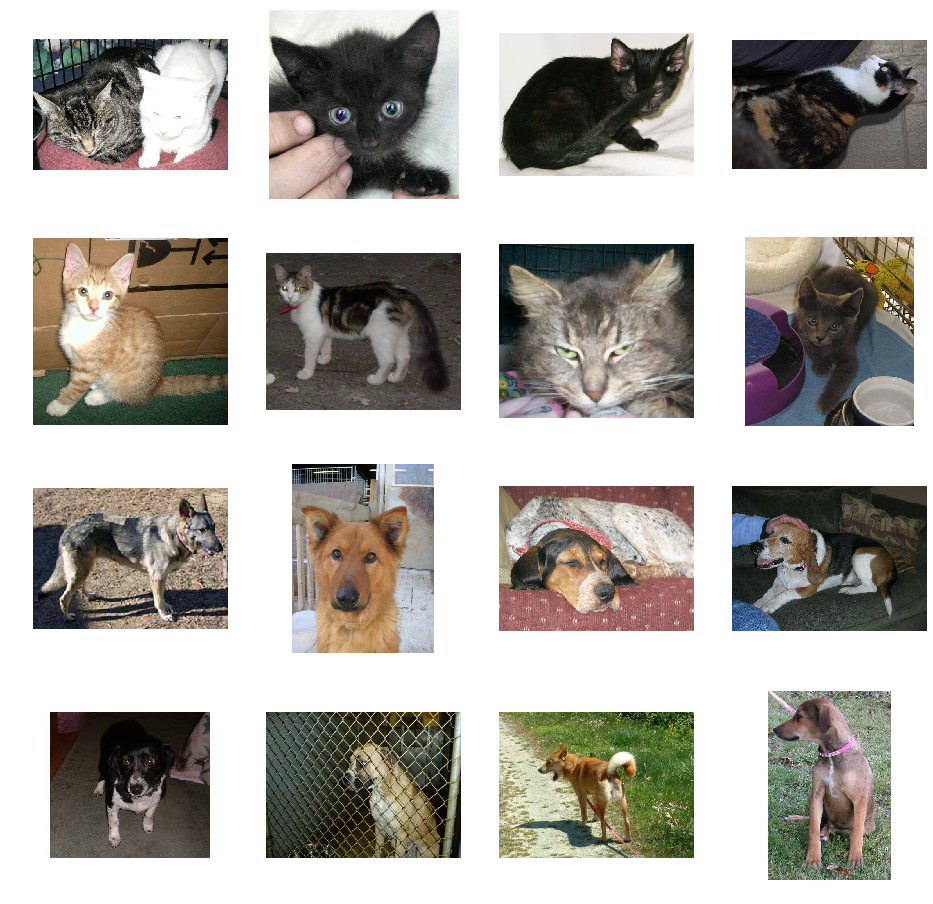

In [8]:
# get the names of the images
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Create the model
Transfer learning using the InceptionV3 model

In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

predictions = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# We freeze the all layers from the InceptionV3 model, so that we only train the newly added
# We can also try to freeze only few of the first layers of the InceptionV3 model to s ee if this will give us better results
for layer in base_model.layers:
    layer.trainable = False

W0724 07:51:34.266051 139676772239232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 07:51:34.307346 139676772239232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 07:51:34.315731 139676772239232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 07:51:34.351238 139676772239232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 07:51:34.352515 1396767722

87916544/87910968 [==============================] - 3s 0us/step


W0724 07:51:55.341242 139676772239232 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# List the layers in the model

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Compile the model

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

W0724 07:52:37.758384 139676772239232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 07:52:37.773105 139676772239232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Create  ImageGenerators for train, validation and test sets

In [0]:
target_width = 299
target_height = 299

In [14]:
# All images will be rescaled by 1./255

# It will be better to add image augmentation, however the validation set will become way smaller than the train set.
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(target_width, target_height),
        batch_size=50,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


# Create a callback that will stop the training once the model stops learning
It will also preserve the best weights with the option `restore_best_weights=True`

In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# Train the model

In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=40,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2,
      callbacks=[es])

Epoch 1/40
 - 31s - loss: 0.6444 - acc: 0.7650 - val_loss: 0.3901 - val_acc: 0.8150
Epoch 2/40
 - 23s - loss: 0.2651 - acc: 0.8985 - val_loss: 0.0544 - val_acc: 0.9900
Epoch 3/40
 - 23s - loss: 0.2429 - acc: 0.9075 - val_loss: 0.1207 - val_acc: 0.9600
Epoch 4/40
 - 23s - loss: 0.2016 - acc: 0.9235 - val_loss: 0.0384 - val_acc: 0.9850
Epoch 5/40
 - 23s - loss: 0.1937 - acc: 0.9260 - val_loss: 0.0538 - val_acc: 0.9800
Epoch 6/40
 - 23s - loss: 0.1543 - acc: 0.9440 - val_loss: 0.0706 - val_acc: 0.9700
Epoch 7/40
 - 23s - loss: 0.1537 - acc: 0.9405 - val_loss: 0.0421 - val_acc: 0.9800
Epoch 8/40
 - 23s - loss: 0.1344 - acc: 0.9485 - val_loss: 0.0736 - val_acc: 0.9700
Epoch 9/40
 - 23s - loss: 0.1564 - acc: 0.9475 - val_loss: 0.0561 - val_acc: 0.9750
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping


In [17]:
print(history.history['val_acc'])

[0.8150000035762787, 0.9899999976158143, 0.9599999904632568, 0.9849999964237213, 0.9799999952316284, 0.9699999988079071, 0.9799999952316284, 0.9699999928474426, 0.9749999940395355]


# Plot the accuracy and loss


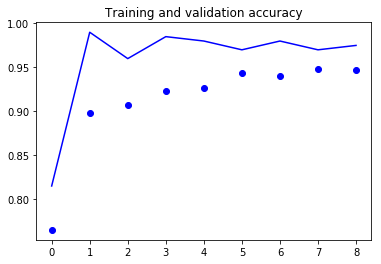

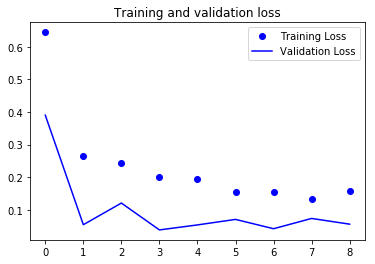

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Plot a confusion matrix based on the test set

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.

  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.3f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

[[246   4]
 [  3 247]]


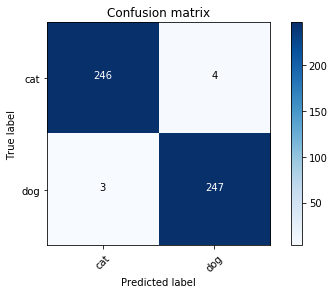

In [20]:
predict = model.predict_generator(test_generator, steps=len(test_generator))

f = lambda x: 1 if x > 0.5 else 0
pr = [f(x) for x in predict]

cm = confusion_matrix(test_generator.classes, pr)

plot_confusion_matrix(cm, ['cat', 'dog'])

# Generate heatmaps based on the test set images

In [0]:
if not os.path.isdir('/tmp/heatmaps'):
  os.mkdir('/tmp/heatmaps')

In [0]:
def prep_image(img_path):
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    return x

def heatmap(model, img_path, n):
  last_conv_layer = model.get_layer("block5_conv3")
  preped = prep_image(img_path)
  img_pred = np.stack([preped], axis=0)
  pred = model.predict(img_pred)
  print(pred)
  class_idx = np.argmax(pred)
  class_output = model.output[:, class_idx]

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(1, 2))
  squeezed_grads = K.squeeze(pooled_grads, 0)

  iterate = K.function([model.input], [squeezed_grads, last_conv_layer.output[0]])
  img = np.expand_dims(preped, axis=0)
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(511):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  to_save = np.concatenate((img, superimposed_img), axis=1)

  cv2.imwrite(os.path.join('/tmp/heatmaps',"NB" + str(n) + "_class:" + str(class_idx) + '.jpg'), to_save)

In [23]:
n = 0

cats = os.listdir(test_cats_dir)
cats_files = [os.path.join(test_cats_dir, cat) for cat in cats]

print(cats_files)

['/tmp/cats_and_dogs_filtered/test/cats/cat.2366.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2344.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2323.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2319.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2113.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2409.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2332.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2408.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2397.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2262.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2023.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2478.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2110.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2487.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2369.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2330.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2166.jpg', '/tmp/cats_and_dogs_filtered/test/cats/cat.2201.jpg', '/tmp/cats_and_dogs_filtere

In [0]:
for img_path in cats_files:
    heatmap(model, img_path, n)
    n += 1

# Visualize convulutional filters

In [0]:
if not os.path.isdir('/tmp/filters'):
  os.mkdir('/tmp/filters')

In [0]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(300, 300),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('/tmp/filters/vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[0]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[0])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)


In [0]:
LAYER_NAME = 'conv2d_12'
visualize_layer(model, LAYER_NAME)

# 17. Visualizing intermediate activations

In [30]:
img = image.load_img(os.path.join(test_cats_dir, 'cat.2007.jpg'), target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

layer_outputs = [layer.output for layer in model.layers[1:10]]
activation_model = keras.models.Model(inputs=model.input,outputs=layer_outputs)
activations = activation_model.predict(x)

layer_names = []
for layer in model.layers[1:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Output hidden; open in https://colab.research.google.com to view.